<a href="https://colab.research.google.com/github/A8stern/PyAD_mobile_2025/blob/main/lab_2_kovalev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2

**Выполнил: Ковалев Глеб К3341 367291**


# 1. Работа с изображением как с NumPy массивом  

Вот исходное изображение, с которым я буду работать.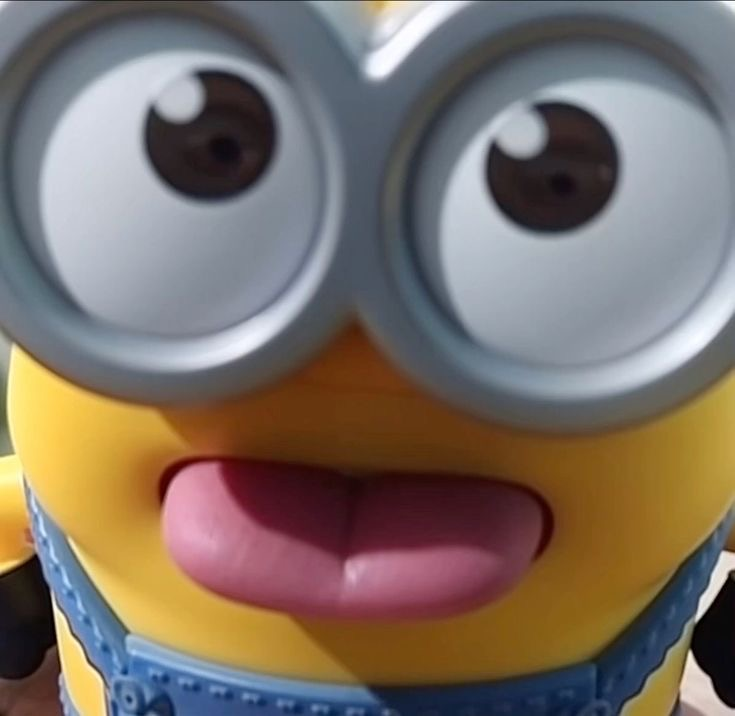

Для начала я загрузил изображение и проверил, что Colab его видит.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

img = iio.imread('IMG_5811.JPG')

print("Форма изображения:", img.shape)

Форма изображения: (716, 735, 3)


Теперь создадим три среза: только с красным, зеленым и синими каналами.

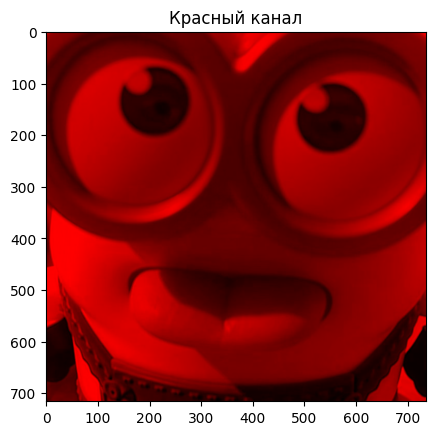

In [65]:
red_channel = img.copy()
red_channel[:, :, 1] = 0
red_channel[:, :, 2] = 0
plt.imshow(red_channel)
plt.title("Красный канал")
plt.show()

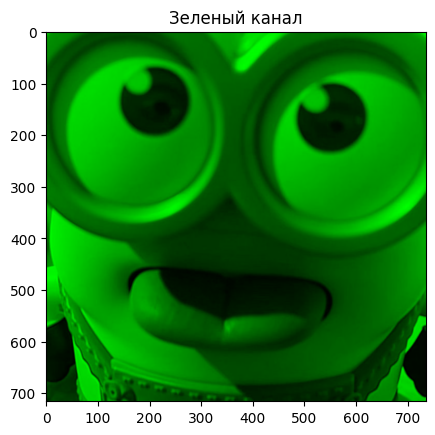

In [66]:
green_channel = img.copy()
green_channel[:, :, 0] = 0
green_channel[:, :, 2] = 0
plt.imshow(green_channel)
plt.title("Зеленый канал")
plt.show()

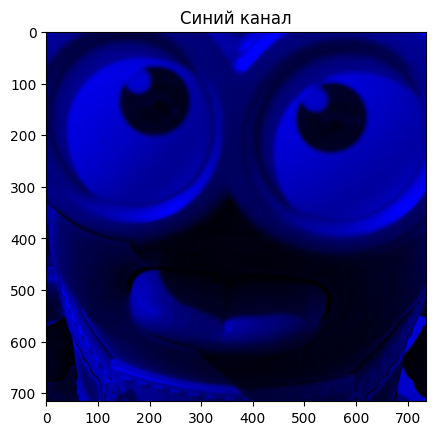

In [67]:
blue_channel = img.copy()
blue_channel[:, :, 0] = 0
blue_channel[:, :, 1] = 0
plt.imshow(blue_channel)
plt.title("Синий канал")
plt.show()

Теперь преобразуем картинку в черно-белую.

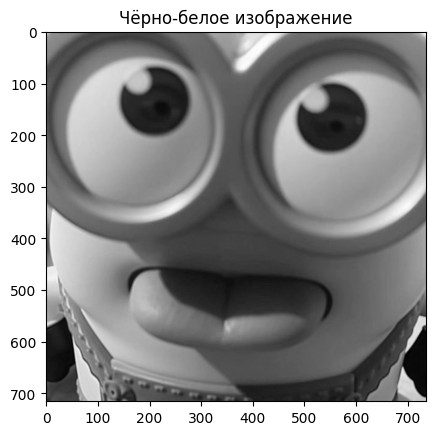

In [68]:
gray = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
gray = gray.astype(np.uint8)
plt.imshow(gray, cmap='gray')
plt.title("Чёрно-белое изображение")
plt.show()

Теперь уменьшим изображение в два раза по каждой оси.

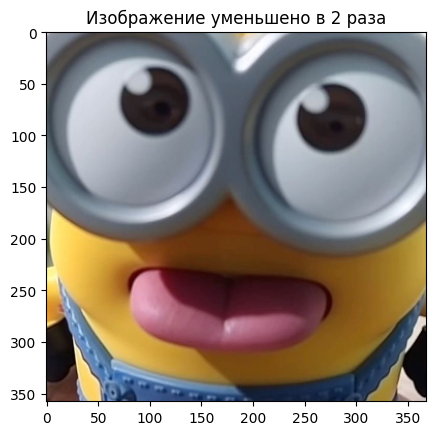

In [69]:
small_img = img[::2, ::2]
plt.imshow(small_img)
plt.title("Изображение уменьшено в 2 раза")
plt.show()

Теперь выберем координаты прямоугольника и заменим все цветные пиксели на черные в этом прямоугольнике.

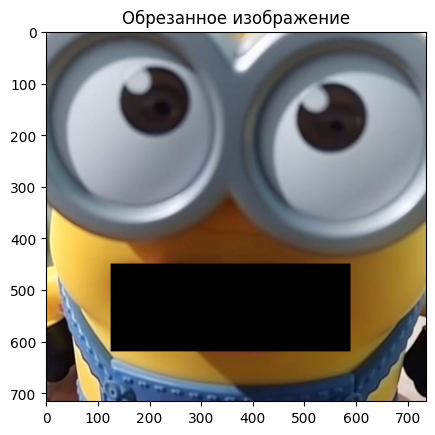

In [70]:
chopped_copy = img.copy()
chopped_copy[450:620, 125:589, :] = 0
plt.imshow(chopped_copy)
plt.title("Обрезанное изображение")
plt.show()

Теперь сделаем горизонтальный, вертикальный и поворот на 180°.

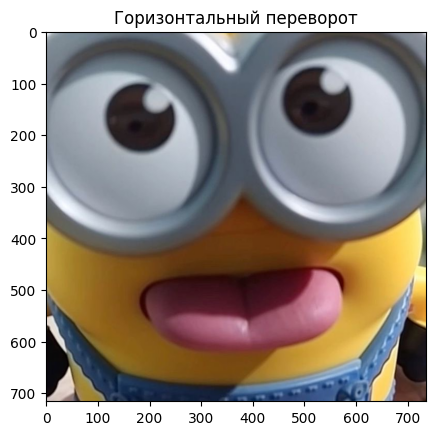

In [71]:
flipped_horizontal = np.flip(img, axis=1)  # и img[:, ::-1]
plt.imshow(flipped_horizontal)
plt.title("Горизонтальный переворот")
plt.show()

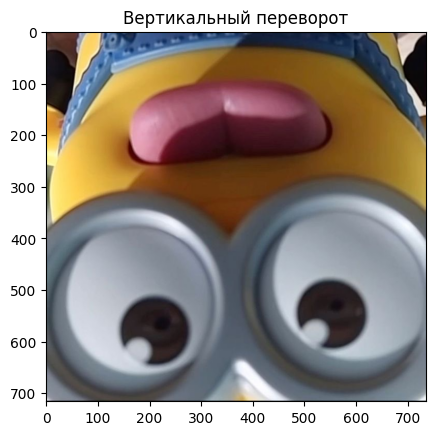

In [72]:
flipped_vertical = np.flip(img, axis=0)  # и img[::-1, :]
plt.imshow(flipped_vertical)
plt.title("Вертикальный переворот")
plt.show()

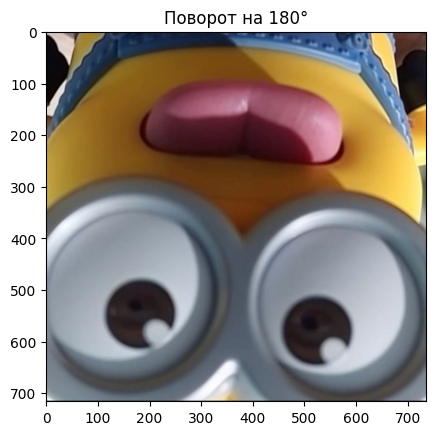

In [73]:
rotated_180 = np.flip(img, axis=(0, 1))
plt.imshow(rotated_180)
plt.title("Поворот на 180°")
plt.show()

Теперь сделаем изображение “теплее”, "холоднее", увелим контрастность и изменим яркость в обе стороны .

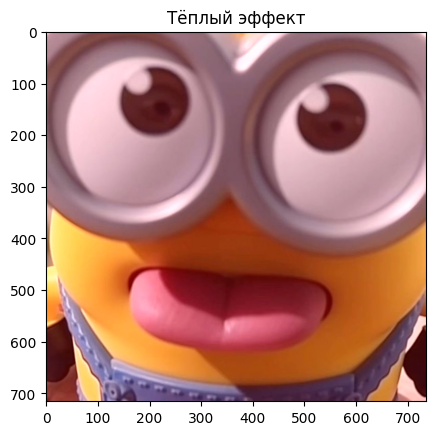

In [74]:
filter = np.array([50, 0, 0])
img_warmer = img + filter
img_warmer = np.clip(img_warmer, 0, 255).astype(np.uint8)

plt.imshow(img_warmer)
plt.title("Тёплый эффект")
plt.show()

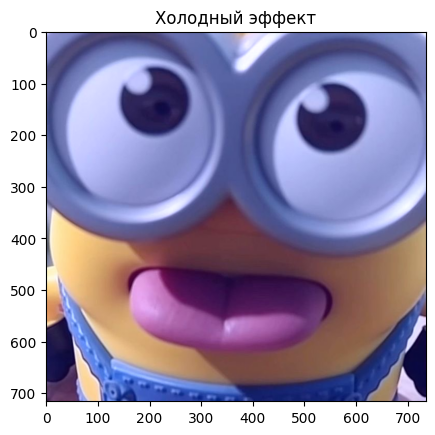

In [75]:
filter = np.array([0, 0, 50])
img_colder = img + filter
img_colder = np.clip(img_colder, 0, 255).astype(np.uint8)

plt.imshow(img_colder)
plt.title("Холодный эффект")
plt.show()

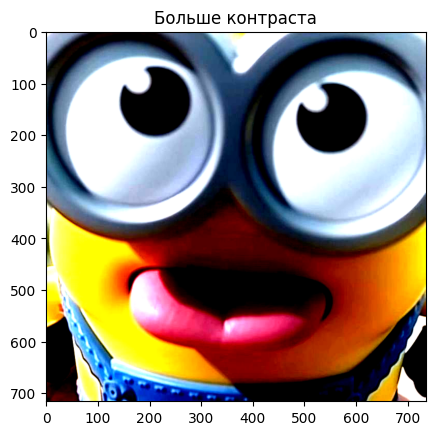

In [76]:
mean_grey = img.mean()
img_contrast = 3 * (img - mean_grey) + mean_grey
img_contrast = np.clip(img_contrast, 0, 255).astype(np.uint8)

plt.imshow(img_contrast)
plt.title("Больше контраста")
plt.show()

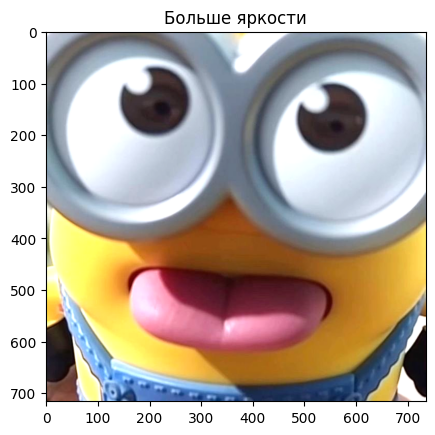

In [77]:
img_brighter = img * 1.4
img_brighter = np.clip(img_brighter, 0, 255).astype(np.uint8)

plt.imshow(img_brighter)
plt.title("Больше яркости")
plt.show()

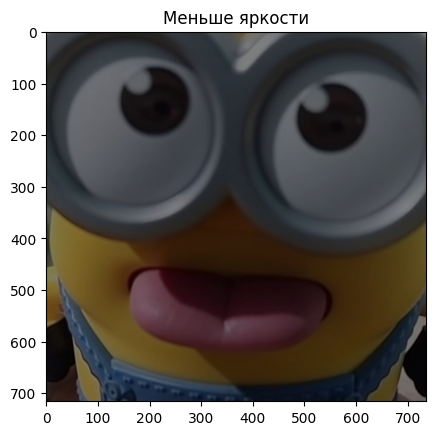

In [78]:
img_meaner = img * 0.5
img_meaner = np.clip(img_meaner, 0, 255).astype(np.uint8)

plt.imshow(img_meaner)
plt.title("Меньше яркости")
plt.show()

Теперь создадим градиентную маску и наложим её.

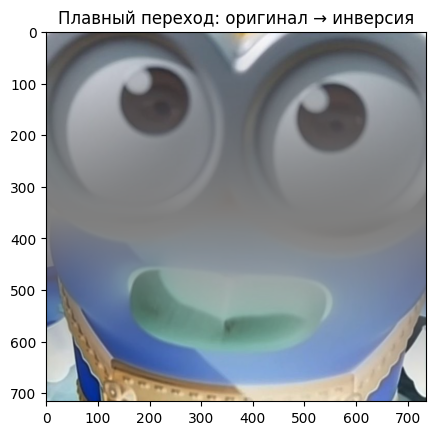

In [79]:
H, W = img.shape[:2]
gradient = np.linspace(0, 1, H)[:, None, None]

inverted = 255 - img
blended = (img * (1 - gradient) + inverted * gradient).astype(np.uint8)
plt.imshow(blended)
plt.title("Плавный переход: оригинал → инверсия")
plt.show()

# Реализация kNN — сравнение чистого Python и NumPy

> **Цель**: Проанализировать разницу между поэлементными циклами и векторизованными операциями.  
> **Задача**: Реализовать алгоритм k ближайших соседей двумя способами — без библиотек и с NumPy — и сравнить время выполнения.

---

## Что такое kNN?

**k ближайших соседей (k-Nearest Neighbors)** — простой алгоритм классификации:  
> Чтобы классифицировать новый объект — найдите `k` ближайших к нему объектов из обучающей выборки и выберите самый частый класс среди них.

Расстояние обычно считают **евклидовым**:

$$
d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + \dots}
$$

---

## Шаг 1: Подготовим данные

Создадим небольшой набор данных вручную:

In [96]:
import numpy as np
import time

np.random.seed(42)
X_train = np.random.rand(1000, 3) * 100
y_train = np.random.choice(['A', 'B', 'C'], size=1000)

X_test = np.array([50.0, 50.0, 50.0])
k = 15

---

## Шаг 2: Реализация на чистом Python (без NumPy)

In [83]:
def euclidean_distance(point1, point2):
    squared_sum = 0
    for i in range(len(point1)):
        squared_sum += (point1[i] - point2[i]) ** 2
    return squared_sum ** 0.5

def knn_pure_python(X_train, y_train, X_test, k):
    distances = []

    for i in range(len(X_train)):
        x = X_train[i]
        label = y_train[i]
        dist = euclidean_distance(x, X_test)
        distances.append((dist, label))

    distances.sort(key=lambda x: x[0])

    k_labels = [label for _, label in distances[:k]]

    return max(set(k_labels), key=k_labels.count)

prediction = knn_pure_python(X_train.tolist(), y_train.tolist(), X_test.tolist(), k)

print(f"Результат классификации (Python): {prediction}")

Результат классификации (Python): B


---

## Шаг 3: Реализация с NumPy

In [84]:
def knn_numpy(X_train, y_train, X_test, k):
    distances = np.sqrt(np.sum((X_train - X_test) ** 2, axis=1))
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = y_train[k_indices]
    unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
    return unique_labels[np.argmax(counts)]

result_numpy = knn_numpy(X_train, y_train, X_test, k)
print(f"Результат классификации (NumPy): {result_numpy}")

Результат классификации (NumPy): B


---

## Шаг 4: Сравнение и анализ

---

Проанализируем время выполнения функций на Python и NumPy

In [97]:
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return end_time - start_time

time_pure = measure_time(knn_pure_python, X_train.tolist(), y_train.tolist(), X_test.tolist(), k)
time_numpy = measure_time(knn_numpy, X_train, y_train, X_test, k)

print(f"Время выполнения (Python): {time_pure:.6f} секунд")
print(f"Время выполнения (NumPy): {time_numpy:.6f} секунд")
print(f"Ускорение NumPy: {time_pure / time_numpy:.2f}x")

Время выполнения (Python): 0.001385 секунд
Время выполнения (NumPy): 0.000437 секунд
Ускорение NumPy: 3.17x


Как видим, NumPy разительно ускорил работу программы.

---

Теперь проанализируем зависимость от количества выбираемых точек

In [100]:
for i in range (1, 100, 10):
    time_pure = measure_time(knn_pure_python, X_train.tolist(), y_train.tolist(), X_test.tolist(), i)
    time_numpy = measure_time(knn_numpy, X_train, y_train, X_test, i)
    print(f"K: {i}, Время выполнения (Python): {time_pure:.6f} секунд, Время выполнения (NumPy): {time_numpy:.6f} секунд, Ускорение NumPy: {time_pure / time_numpy:.2f}x")

K: 1, Время выполнения (Python): 0.002485 секунд, Время выполнения (NumPy): 0.000557 секунд, Ускорение NumPy: 4.46x
K: 11, Время выполнения (Python): 0.001296 секунд, Время выполнения (NumPy): 0.000336 секунд, Ускорение NumPy: 3.86x
K: 21, Время выполнения (Python): 0.001278 секунд, Время выполнения (NumPy): 0.000351 секунд, Ускорение NumPy: 3.64x
K: 31, Время выполнения (Python): 0.001718 секунд, Время выполнения (NumPy): 0.000278 секунд, Ускорение NumPy: 6.17x
K: 41, Время выполнения (Python): 0.001190 секунд, Время выполнения (NumPy): 0.000269 секунд, Ускорение NumPy: 4.43x
K: 51, Время выполнения (Python): 0.001218 секунд, Время выполнения (NumPy): 0.000278 секунд, Ускорение NumPy: 4.37x
K: 61, Время выполнения (Python): 0.001100 секунд, Время выполнения (NumPy): 0.000229 секунд, Ускорение NumPy: 4.81x
K: 71, Время выполнения (Python): 0.001102 секунд, Время выполнения (NumPy): 0.000241 секунд, Ускорение NumPy: 4.57x
K: 81, Время выполнения (Python): 0.001154 секунд, Время выполнен

Как видим время выполнения меняется от k, однако разницы в ускорении нет, это происходит из-за того, что разница в скорости будет более заметна на большей выборке чисел, что мы и проверим в следующем пункте. Это происходит из-за того, что векторные вычисления остаются одинаковыми. Также так как вычисления еще не выполнены в первый раз время в обоих случаях заметно больше. Далее идет одинаковое время на сортировку в обоих случаях, но мы можем заметить что в NumPy быстрее сортировка и выбор из списка.

---

## Шаг 5: Масштабирование

Изменим количество точек, буду выбирать k как 1% от максимального количества точек.

In [104]:
count = [1000, 10000, 100000]

for val in count:
    np.random.seed(42)
    X_train = np.random.rand(val, 3) * 100
    y_train = np.random.choice(['A', 'B', 'C'], size=val)

    X_test = np.array([50.0, 50.0, 50.0])
    k = val // 100
    time_pure = measure_time(knn_pure_python, X_train.tolist(), y_train.tolist(), X_test.tolist(), k)
    time_numpy = measure_time(knn_numpy, X_train, y_train, X_test, k)
    print(f"Количество точек: {val}, Время выполнения (Python): {time_pure:.6f} секунд, Время выполнения (NumPy): {time_numpy:.6f} секунд, Ускорение NumPy: {time_pure / time_numpy:.2f}x")

Количество точек: 1000, Время выполнения (Python): 0.002720 секунд, Время выполнения (NumPy): 0.000723 секунд, Ускорение NumPy: 3.76x
Количество точек: 10000, Время выполнения (Python): 0.018527 секунд, Время выполнения (NumPy): 0.001386 секунд, Ускорение NumPy: 13.37x
Количество точек: 100000, Время выполнения (Python): 0.377721 секунд, Время выполнения (NumPy): 0.008320 секунд, Ускорение NumPy: 45.40x


Как раз тут мы видим значительное ускорение NumPy из-за возросшего количества точек, с ростом количества данных NumPy показывает себя лучше.